In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

from abs_cam import AbsCAMInit, AbsCAMFinal
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from utils import *
from evaluation import CausalMetric, auc, gkern

import zipfile

In [2]:
import os
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms, datasets

os.makedirs("unseen_images/class0", exist_ok=True)

urls = [
    "https://images.unsplash.com/photo-1583337130417-3346a1be7dee",
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d",
    "https://images.unsplash.com/photo-1558788353-f76d92427f16",
    "https://images.unsplash.com/photo-1574158622682-e40e69881006",
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/115.0.0.0 Safari/537.36"
}

for i, url in enumerate(urls):
    try:
        response = requests.get(url, timeout=10, headers=headers)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(f"unseen_images/class0/img_{i:02d}.jpg")
        print(f"Скачано: {url}")
    except Exception as e:
        print(f"Ошибка при скачивании {url}: {e}")

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_dataset = datasets.ImageFolder("unseen_images", transform=val_transform)
val_dataset.samples = [(path, 0) for path, _ in val_dataset.samples]
val_dataset.targets = [0] * len(val_dataset)

print(f"Всего изображений в val_dataset: {len(val_dataset)}")


Скачано: https://images.unsplash.com/photo-1583337130417-3346a1be7dee
Скачано: https://images.unsplash.com/photo-1518717758536-85ae29035b6d
Скачано: https://images.unsplash.com/photo-1558788353-f76d92427f16
Скачано: https://images.unsplash.com/photo-1574158622682-e40e69881006
Всего изображений в val_dataset: 4


In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # автоматический выбор CUDA или CPU
device

device(type='cuda')

In [4]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
class_names = weights.meta["categories"]
class_names

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [6]:
len(class_names)

1000

In [7]:
explainer_init = AbsCAMInit(model, target_layer='layer4', device=device)
explainer_final = AbsCAMFinal(model, target_layer='layer4', device=device)

saliency_init: 0.0 1.0 0.2991602122783661
saliency_final: 0.0 17.7799015045166 5.3190388679504395
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constr

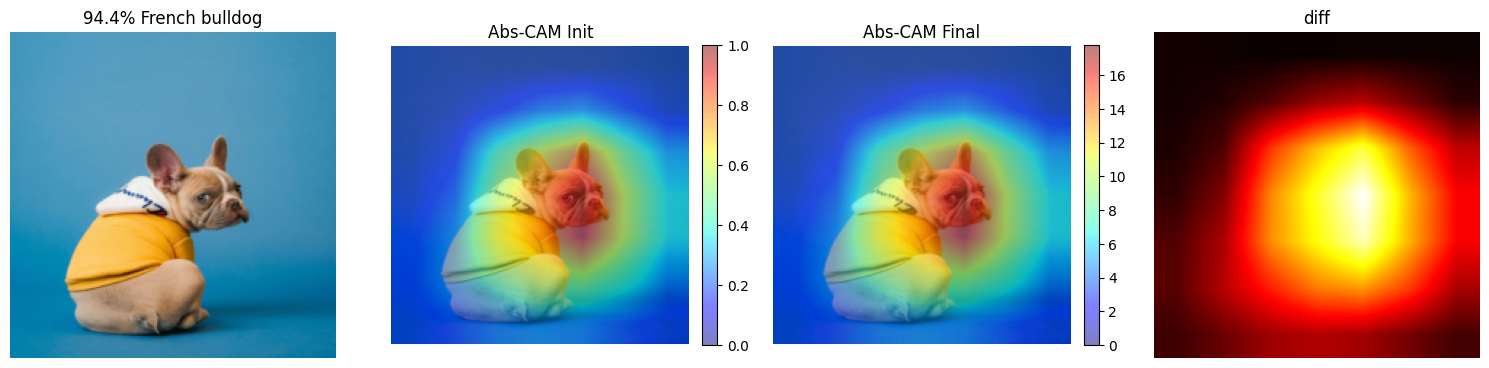

In [8]:
def explain_and_plot(img, label=None, class_names=None):
    saliency_init = explainer_init(img).astype(np.float32)
    saliency_final = explainer_final(img).astype(np.float32)

    print("saliency_init:", saliency_init.min().item(), saliency_init.max().item(), saliency_init.mean().item())
    print("saliency_final:", saliency_final.min().item(), saliency_final.max().item(), saliency_final.mean().item())

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        print(class_names)
        class_name = class_names[class_idx.item()]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.axis('off')
    plt.title(f'{100 * conf.item():.1f}% {class_name}')
    tensor_imshow(img[0].cpu())

    # Abs-CAM Init
    plt.subplot(1, 4, 2)
    plt.axis('off')
    plt.title('Abs-CAM Init')
    tensor_imshow(img[0].cpu())
    plt.imshow(saliency_init, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    # Abs-CAM Final
    plt.subplot(1, 4, 3)
    plt.axis('off')
    plt.title('Abs-CAM Final')
    tensor_imshow(img[0].cpu())
    plt.imshow(saliency_final, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.title('diff')
    diff = np.abs(saliency_final - saliency_init)
    plt.imshow(diff, cmap='hot')

    plt.tight_layout()
    plt.show()


sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.4446163475513458
saliency_final: 0.0 12.31143569946289 5.473865032196045
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constr

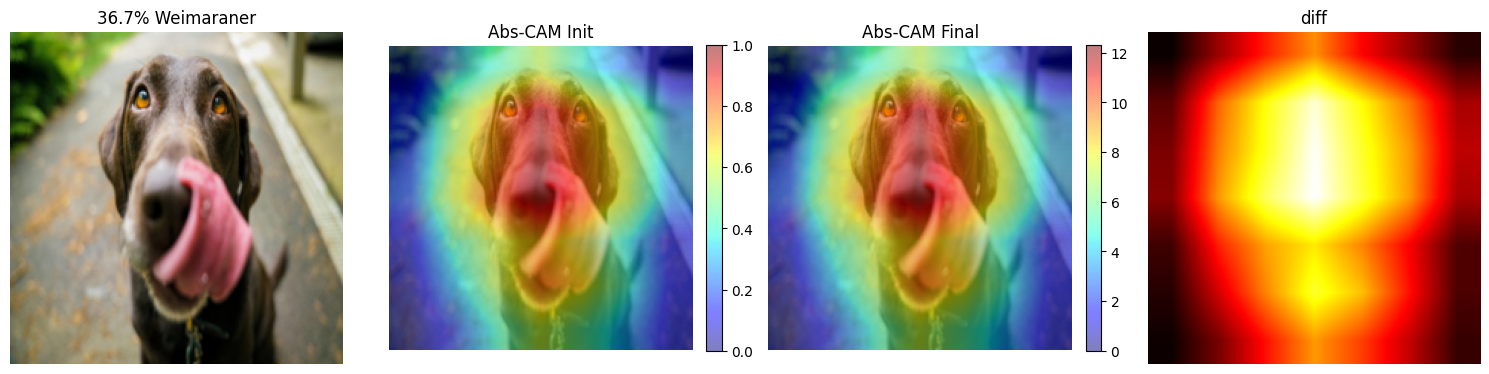

In [9]:
sample_img, label = val_dataset[1]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.5251476764678955
saliency_final: 0.0 16.67353057861328 8.756065368652344
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constr

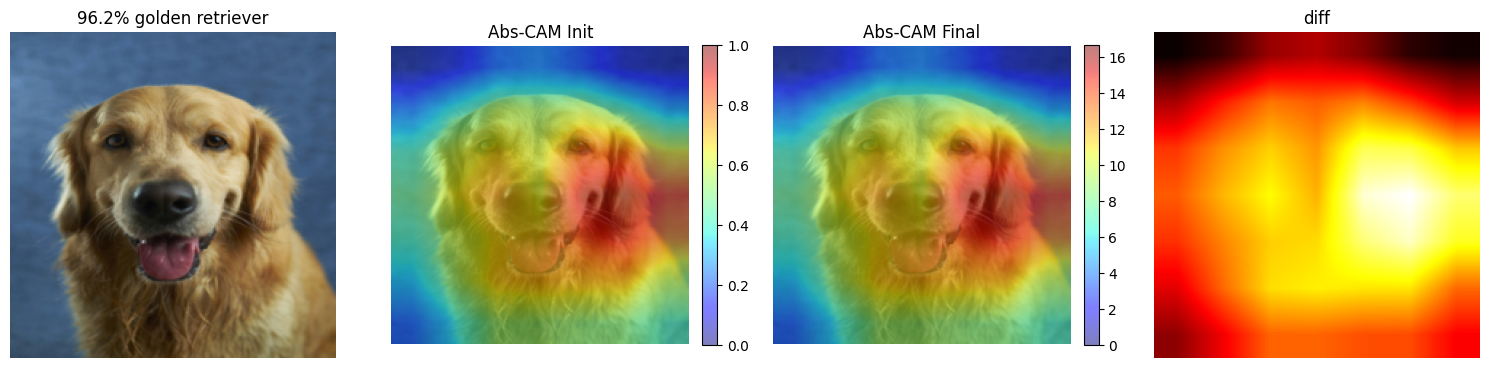

In [10]:
sample_img, label = val_dataset[2]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.4568026661872864
saliency_final: 0.0 14.73411750793457 6.730584621429443
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constr

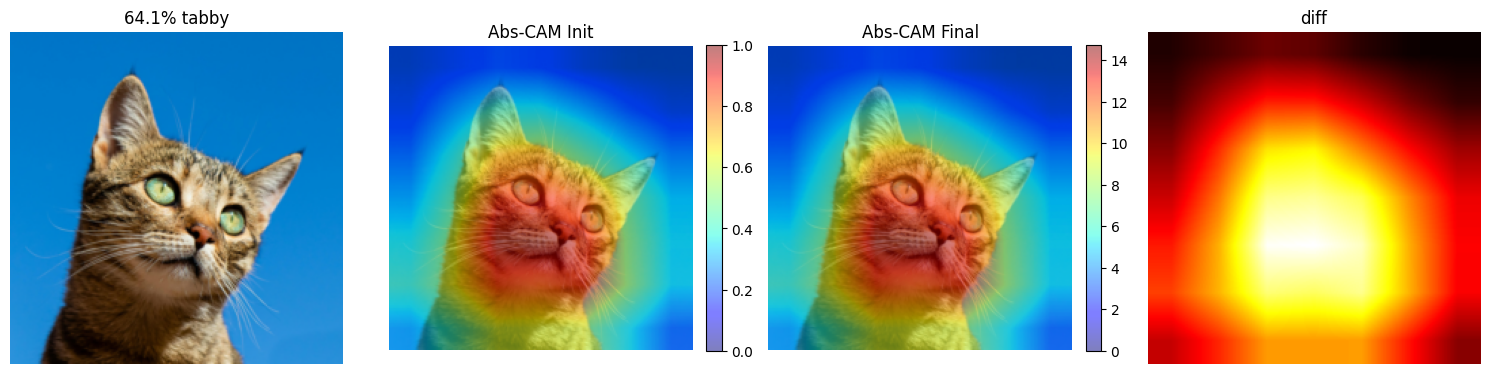

In [11]:
sample_img, label = val_dataset[3]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

In [12]:
from abs_cam import AbsCAMInit 

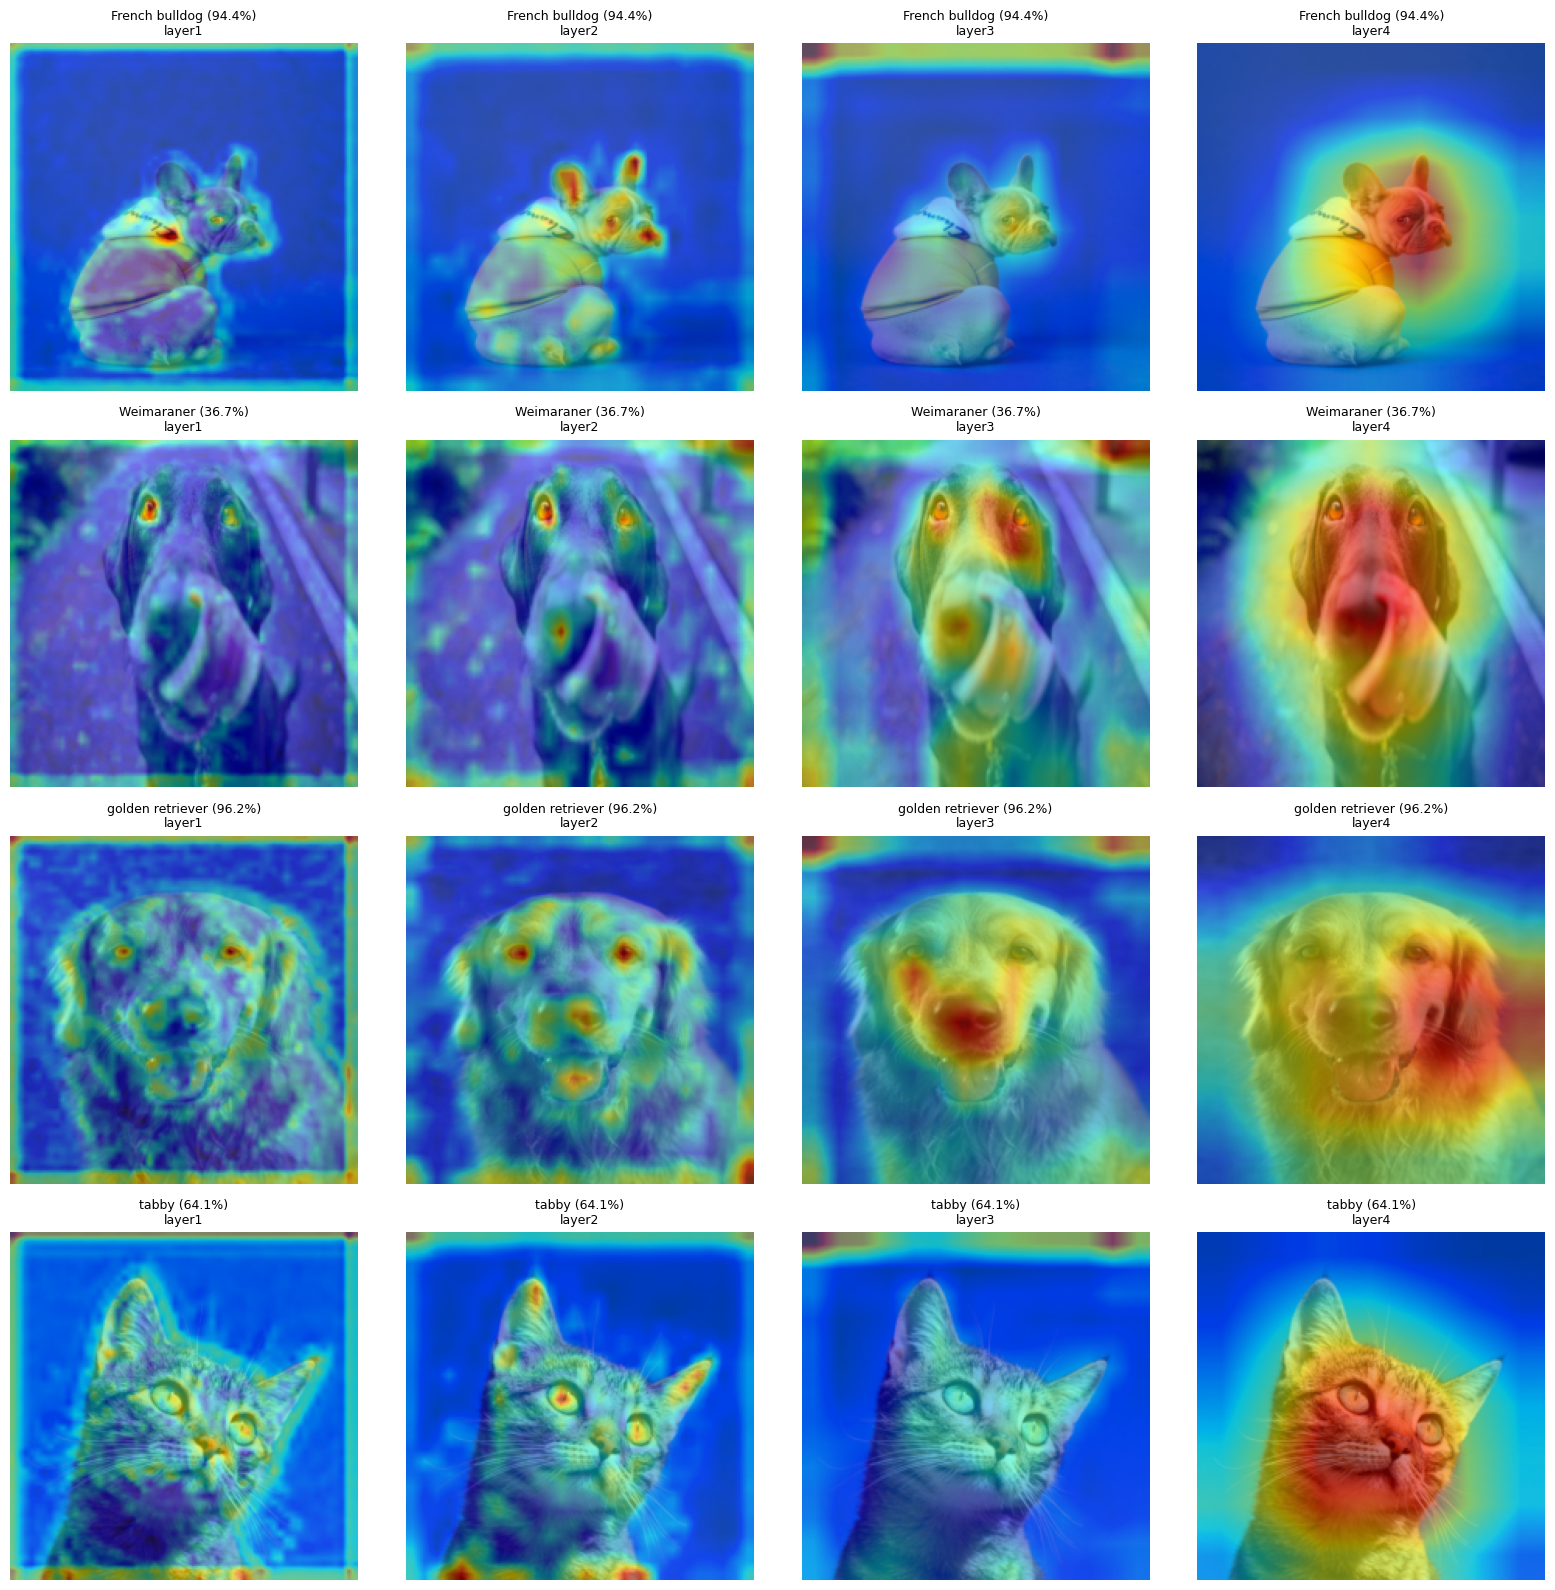

In [13]:
layers_to_check = ['layer1', 'layer2', 'layer3', 'layer4']
num_images = 4

# indices = random.sample(range(len(val_dataset)), num_images)
indices = [0, 1,2,3]
images = [val_dataset[i][0].unsqueeze(0).to(device) for i in indices]

plt.figure(figsize=(len(layers_to_check) * 4, num_images * 4))

for row_idx, img in enumerate(images):
    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        class_name = class_names[class_idx.item()]

    for col_idx, layer in enumerate(layers_to_check):
        explainer = AbsCAMInit(model, target_layer=layer, device=device)
        saliency = explainer(img).astype(np.float32)

        plt_idx = row_idx * len(layers_to_check) + col_idx + 1
        plt.subplot(num_images, len(layers_to_check), plt_idx)
        plt.axis('off')
        plt.title(f"{class_name} ({conf.item()*100:.1f}%)\n{layer}", fontsize=9)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency, cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()

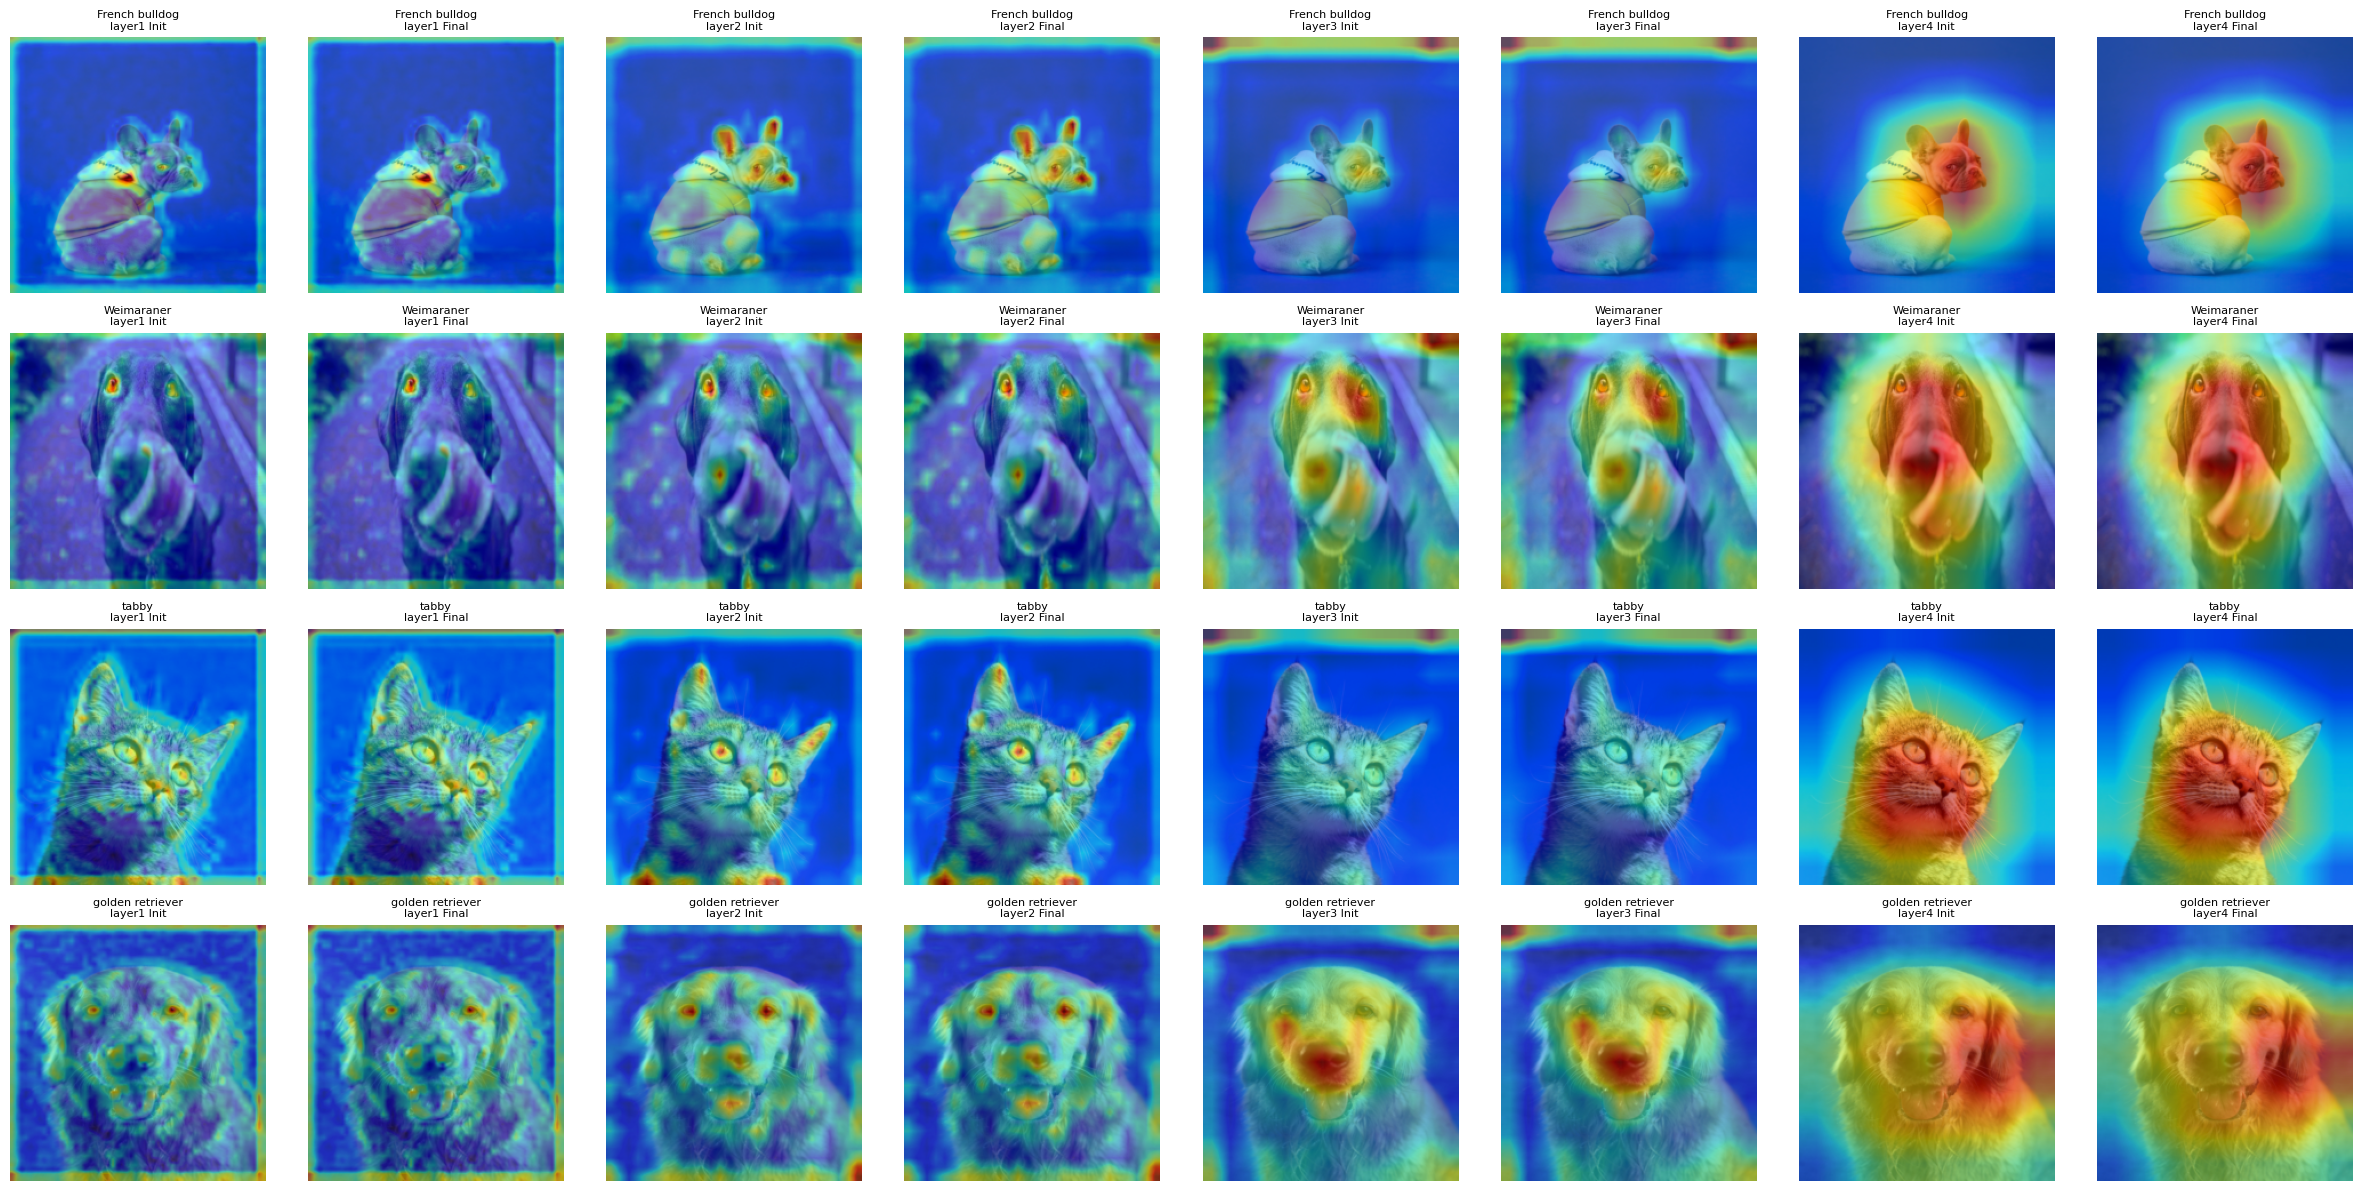

In [14]:
layers_to_check = ['layer1', 'layer2', 'layer3', 'layer4']
num_images = 4

indices = random.sample(range(len(val_dataset)), num_images)
images = [val_dataset[i][0].unsqueeze(0).to(device) for i in indices]

plt.figure(figsize=(len(layers_to_check) * 2 * 3, num_images * 3))

for row_idx, img in enumerate(images):
    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        class_name = class_names[class_idx.item()]

    for col_idx, layer in enumerate(layers_to_check):
        explainer_init = AbsCAMInit(model, target_layer=layer, device=device)
        explainer_final = AbsCAMFinal(model, target_layer=layer, device=device)

        saliency_init = explainer_init(img).astype(np.float32)
        saliency_final = explainer_final(img).astype(np.float32)

        # Init map
        idx_init = row_idx * len(layers_to_check) * 2 + col_idx * 2 + 1
        plt.subplot(num_images, len(layers_to_check) * 2, idx_init)
        plt.axis('off')
        plt.title(f"{class_name}\n{layer} Init", fontsize=8)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency_init, cmap='jet', alpha=0.5)

        # Final map
        idx_final = row_idx * len(layers_to_check) * 2 + col_idx * 2 + 2
        plt.subplot(num_images, len(layers_to_check) * 2, idx_final)
        plt.axis('off')
        plt.title(f"{class_name}\n{layer} Final", fontsize=8)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency_final, cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()


In [15]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern.to(x.device), padding=klen//2)

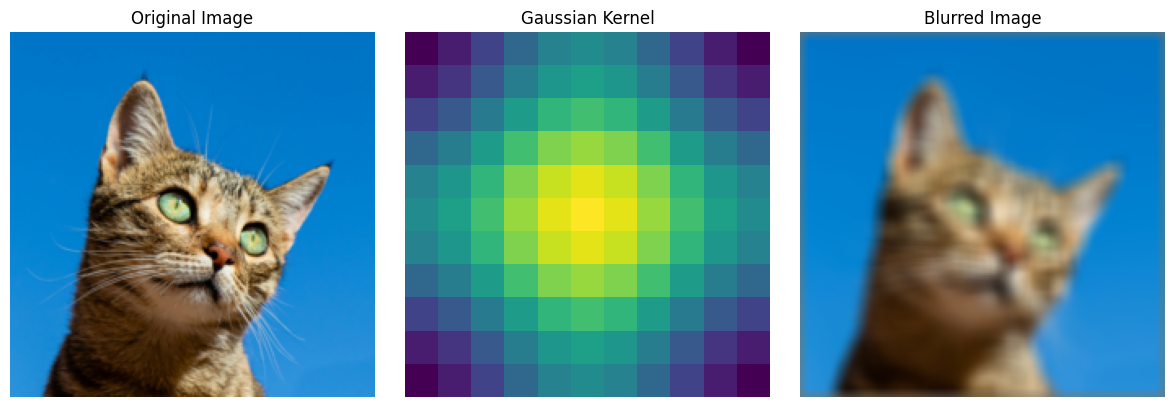

In [16]:
def plot_blur(img):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.title("Original Image")
    tensor_imshow(img[0])

    plt.subplot(132)
    plt.axis('off')
    plt.title("Gaussian Kernel")
    plt.imshow(kern[0, 0])

    plt.subplot(133)
    plt.axis('off')
    plt.title("Blurred Image")
    tensor_imshow(blur(img)[0])

    plt.tight_layout()
    plt.show()

sample_img, label = val_dataset[3]
sample_img = sample_img.unsqueeze(0).to(device)
plot_blur(sample_img)

In [17]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [18]:
sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)
saliency = explainer(sample_img).astype(np.float32)

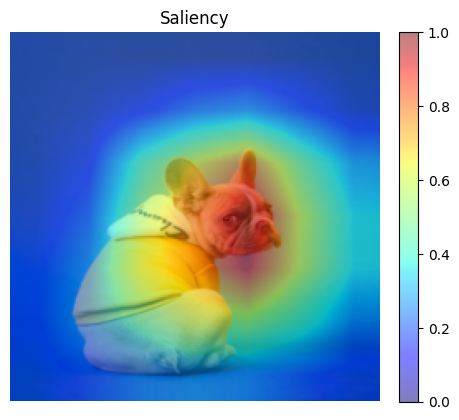

In [19]:
plt.axis('off')
plt.title('Saliency')
tensor_imshow(sample_img[0])
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.046, pad=0.04)

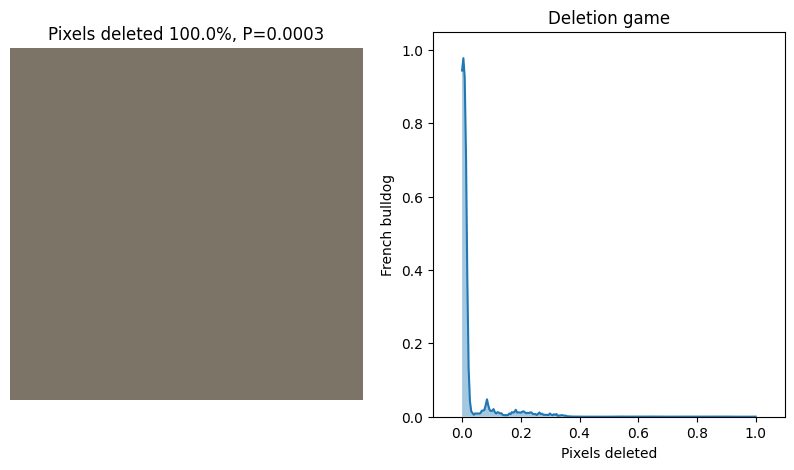

In [20]:
h = deletion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

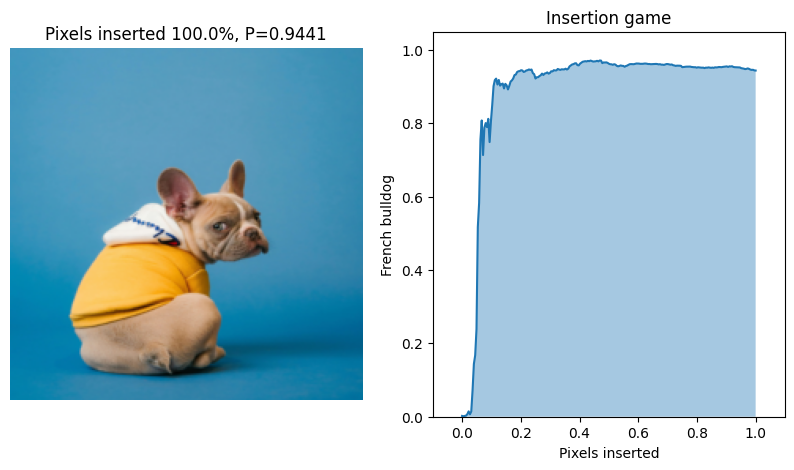

In [21]:
h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

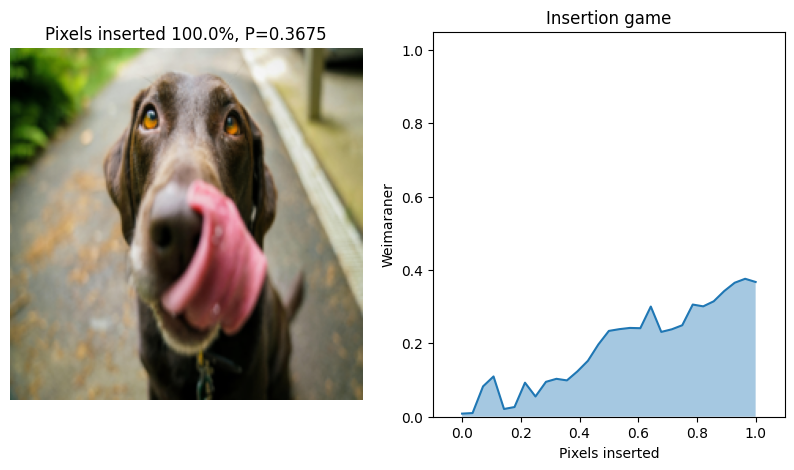

In [28]:
sample_img, label = val_dataset[1]
sample_img = sample_img.unsqueeze(0).to(device)
saliency = explainer(sample_img).astype(np.float32)

h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

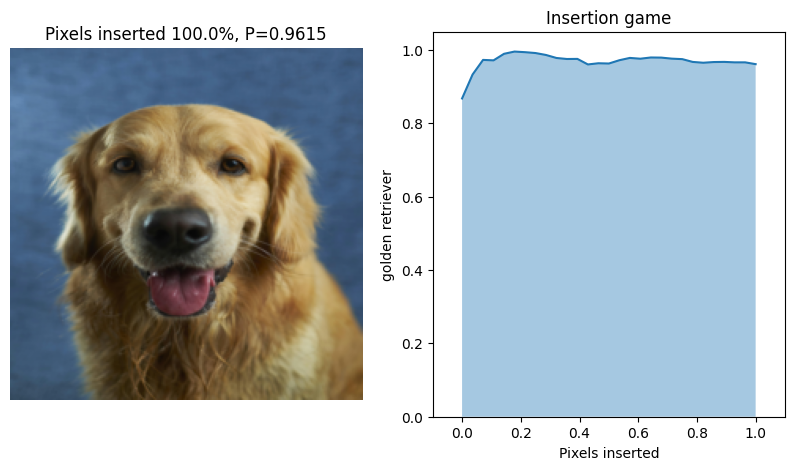

In [29]:
sample_img, label = val_dataset[2]
sample_img = sample_img.unsqueeze(0).to(device)
saliency = explainer(sample_img).astype(np.float32)

h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

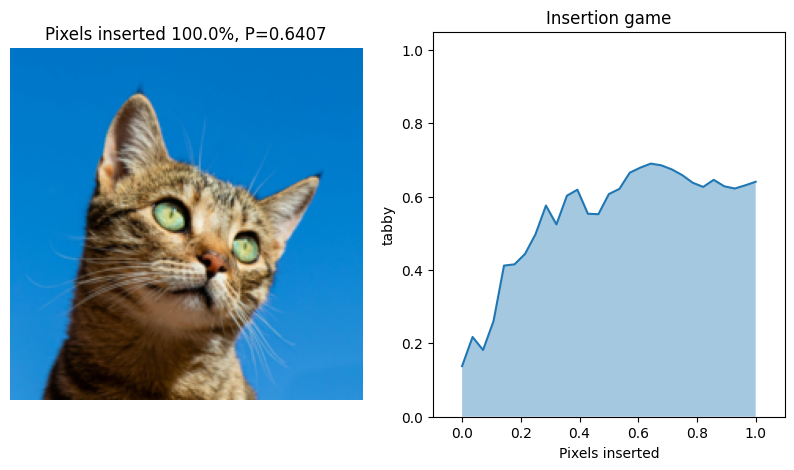

In [30]:
sample_img, label = val_dataset[3]
sample_img = sample_img.unsqueeze(0).to(device)
saliency = explainer(sample_img).astype(np.float32)

h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

In [23]:
images = []
explanations = []

for i in range(len(val_dataset)):
    img, _ = val_dataset[i]
    img = img.unsqueeze(0).to(device)
    saliency = explainer(img).astype(np.float32)
    saliency = explainer(img).astype(np.float32)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    
    images.append(img.squeeze(0).cpu())
    explanations.append(saliency)

images_tensor = torch.stack(images).to(device)
saliency_np = np.stack(explanations)

insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)
h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)

print('Deletion AUC:', auc(h_del.mean(1)))
print('Insertion AUC:', auc(h_ins.mean(1)))


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 31.29it/s]


AUC: 0.09467194178645448


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.33it/s]

AUC: 0.650353344515939
Deletion AUC: 0.09467194178645448
Insertion AUC: 0.650353344515939


In [24]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
results = {}

for layer in layers:
    print(f"\nEvaluating for layer: {layer}")
    explainer = AbsCAMInit(model, target_layer=layer, device=device)
    
    images = []
    explanations = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        images.append(img.squeeze(0).cpu())
        explanations.append(saliency)

    images_tensor = torch.stack(images).to(device)
    saliency_np = np.stack(explanations)

    insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
    deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

    h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)
    h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)

    deletion_auc = auc(h_del.mean(1))
    insertion_auc = auc(h_ins.mean(1))

    print(f"Layer {layer} — Deletion AUC: {deletion_auc:.4f}, Insertion AUC: {insertion_auc:.4f}")
    results[layer] = {'deletion_auc': deletion_auc, 'insertion_auc': insertion_auc}


Evaluating for layer: layer1


Deleting  pixels: 100%|██████████| 29/29 [00:01<00:00, 28.80it/s]


AUC: 0.13101006863023304


Inserting pixels: 100%|██████████| 29/29 [00:01<00:00, 28.05it/s]


AUC: 0.5693512958064925
Layer layer1 — Deletion AUC: 0.1310, Insertion AUC: 0.5694

Evaluating for layer: layer2


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 29.59it/s]


AUC: 0.09060967273219436


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.77it/s]


AUC: 0.6237984182547994
Layer layer2 — Deletion AUC: 0.0906, Insertion AUC: 0.6238

Evaluating for layer: layer3


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 30.74it/s]


AUC: 0.11691335758409391


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.95it/s]


AUC: 0.6284324975152101
Layer layer3 — Deletion AUC: 0.1169, Insertion AUC: 0.6284

Evaluating for layer: layer4


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 30.18it/s]


AUC: 0.09467194178645448


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 32.71it/s]

AUC: 0.650353344515939
Layer layer4 — Deletion AUC: 0.0947, Insertion AUC: 0.6504


In [25]:
for layer in layers:
    print(f"Layer {layer} — Deletion AUC: {results[layer]['deletion_auc']:.4f}, Insertion AUC: {results[layer]['insertion_auc']:.4f}")

Layer layer1 — Deletion AUC: 0.1310, Insertion AUC: 0.5694
Layer layer2 — Deletion AUC: 0.0906, Insertion AUC: 0.6238
Layer layer3 — Deletion AUC: 0.1169, Insertion AUC: 0.6284
Layer layer4 — Deletion AUC: 0.0947, Insertion AUC: 0.6504


In [26]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
results = {}

for layer in layers:
    print(f"\nEvaluating for layer: {layer}")

    # --- AbsCAMInit ---
    explainer_init = AbsCAMInit(model, target_layer=layer, device=device)
    
    images = []
    explanations_init = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer_init(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        images.append(img.squeeze(0).cpu())
        explanations_init.append(saliency)

    images_tensor = torch.stack(images).to(device)
    saliency_np_init = np.stack(explanations_init)

    insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
    deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

    h_del_init = deletion.evaluate(images_tensor, saliency_np_init, device=device, batch_size=1)
    h_ins_init = insertion.evaluate(images_tensor, saliency_np_init, device=device, batch_size=1)

    deletion_auc_init = auc(h_del_init.mean(1))
    insertion_auc_init = auc(h_ins_init.mean(1))

    print(f"AbsCAMInit @ {layer} — Deletion AUC: {deletion_auc_init:.4f}, Insertion AUC: {insertion_auc_init:.4f}")
    
    # --- AbsCAMFinal ---
    explainer_final = AbsCAMFinal(model, target_layer=layer, device=device)
    explanations_final = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer_final(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        explanations_final.append(saliency)

    saliency_np_final = np.stack(explanations_final)

    h_del_final = deletion.evaluate(images_tensor, saliency_np_final, device=device, batch_size=1)
    h_ins_final = insertion.evaluate(images_tensor, saliency_np_final, device=device, batch_size=1)

    deletion_auc_final = auc(h_del_final.mean(1))
    insertion_auc_final = auc(h_ins_final.mean(1))

    print(f"AbsCAMFinal @ {layer} — Deletion AUC: {deletion_auc_final:.4f}, Insertion AUC: {insertion_auc_final:.4f}")

    results[layer] = {
        'init': {'deletion_auc': deletion_auc_init, 'insertion_auc': insertion_auc_init},
        'final': {'deletion_auc': deletion_auc_final, 'insertion_auc': insertion_auc_final}
    }

for layer in layers:
    print(f"\nLayer {layer}:")
    print(f"  AbsCAMInit  — Deletion AUC: {results[layer]['init']['deletion_auc']:.4f}, Insertion AUC: {results[layer]['init']['insertion_auc']:.4f}")
    print(f"  AbsCAMFinal — Deletion AUC: {results[layer]['final']['deletion_auc']:.4f}, Insertion AUC: {results[layer]['final']['insertion_auc']:.4f}")



Evaluating for layer: layer1


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 29.55it/s]


AUC: 0.13101006877758742


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 32.73it/s]


AUC: 0.5693468682989727
AbsCAMInit @ layer1 — Deletion AUC: 0.1310, Insertion AUC: 0.5693


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 32.45it/s]


AUC: 0.13101006863023304


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.40it/s]


AUC: 0.5693512958064925
AbsCAMFinal @ layer1 — Deletion AUC: 0.1310, Insertion AUC: 0.5694

Evaluating for layer: layer2


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 30.33it/s]


AUC: 0.09060967273219436


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.39it/s]


AUC: 0.6237984182547994
AbsCAMInit @ layer2 — Deletion AUC: 0.0906, Insertion AUC: 0.6238


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 31.13it/s]


AUC: 0.09060967273219436


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 32.40it/s]


AUC: 0.6237984182547994
AbsCAMFinal @ layer2 — Deletion AUC: 0.0906, Insertion AUC: 0.6238

Evaluating for layer: layer3


Deleting  pixels: 100%|██████████| 29/29 [00:01<00:00, 23.79it/s]


AUC: 0.11691335758409391


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 29.92it/s]


AUC: 0.6284324975152101
AbsCAMInit @ layer3 — Deletion AUC: 0.1169, Insertion AUC: 0.6284


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 30.75it/s]


AUC: 0.11691335758409391


Inserting pixels: 100%|██████████| 29/29 [00:00<00:00, 31.39it/s]


AUC: 0.6284324975152101
AbsCAMFinal @ layer3 — Deletion AUC: 0.1169, Insertion AUC: 0.6284

Evaluating for layer: layer4


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 29.80it/s]


AUC: 0.09467194178645448


Inserting pixels: 100%|██████████| 29/29 [00:01<00:00, 26.96it/s]


AUC: 0.650353344515939
AbsCAMInit @ layer4 — Deletion AUC: 0.0947, Insertion AUC: 0.6504


Deleting  pixels: 100%|██████████| 29/29 [00:00<00:00, 30.52it/s]


AUC: 0.09467194178645448


Inserting pixels: 100%|██████████| 29/29 [00:01<00:00, 26.99it/s]

AUC: 0.650353344515939
AbsCAMFinal @ layer4 — Deletion AUC: 0.0947, Insertion AUC: 0.6504

Layer layer1:
  AbsCAMInit  — Deletion AUC: 0.1310, Insertion AUC: 0.5693
  AbsCAMFinal — Deletion AUC: 0.1310, Insertion AUC: 0.5694

Layer layer2:
  AbsCAMInit  — Deletion AUC: 0.0906, Insertion AUC: 0.6238
  AbsCAMFinal — Deletion AUC: 0.0906, Insertion AUC: 0.6238

Layer layer3:
  AbsCAMInit  — Deletion AUC: 0.1169, Insertion AUC: 0.6284
  AbsCAMFinal — Deletion AUC: 0.1169, Insertion AUC: 0.6284

Layer layer4:
  AbsCAMInit  — Deletion AUC: 0.0947, Insertion AUC: 0.6504
  AbsCAMFinal — Deletion AUC: 0.0947, Insertion AUC: 0.6504
